required libraries

In [437]:
import seaborn
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import copy
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.losses import Huber
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.models import load_model
import joblib
import random
import os


loading file

In [309]:

file_path = r'Data Prediction Data - Final - Eng.xlsx'
df = pd.read_excel(file_path)

df.columns = df.columns.map(str)



plotting data types of columns, stats

In [219]:

print("Available Columns in DataFrame:")
print(df.columns.tolist())

print("\n-----------------------------------------------------------------\nColumn Names\t\t\t\tData Types:")
print(df.dtypes)

print("\n-----------------------------------------------------------------\nStatistical Summary (Numerical Columns):")
print(df.describe())



Available Columns in DataFrame:
['History', 'Product Name', 'Batch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'Batch off Release Time', 'Ext Entry time', '20', '21', '22', '24', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'Test Date/Time', 'Elastagraph watch', 'Time between B/off - Elastagrof', 'Hour', 'Minute', 'Second']

-----------------------------------------------------------------
Column Names				Data Types:
History                            datetime64[ns]
Product Name                                int64
Batch                                       int64
1                                         float64
2                                         float64
3                                         float64
4                                         float64
5                                         float64
6                                         float64
7                                         float64
8               

1) Setting Input and Target variables
2) converting the time variables to datetime variable
3) converting the datatypes of other variables to float64

In [310]:
time_columns = ['Batch off Release Time','Ext Entry time','Test Date/Time']
for col in time_columns:
    #df[col] = df[col].astype(str).apply(ensure_date_and_convert)
    df[col] = pd.to_datetime(df[col], format='%H:%M:%S', errors='coerce').fillna(
                    pd.to_datetime(df[col], format='%m/%d/%Y %H:%M:%S', errors='coerce'))
    df[col] = df[col].dt.hour * 3600 + df[col].dt.minute * 60 + df[col].dt.second

numeric_columns = set(x + y) - set(time_columns)
df[list(numeric_columns)] = df[list(numeric_columns)].apply(pd.to_numeric, errors='coerce').astype('float64')


1) making a dataframe copy having inputs and output variables only
2) finding and dealing with missing values (setting median)

In [311]:

x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '21', '22', '24', 'Batch off Release Time', 'Ext Entry time']
y = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'Test Date/Time']

df_xy = copy.deepcopy(df[x + y])

df_xy = df_xy.apply(pd.to_numeric, errors='coerce')

df_xy.fillna(df_xy.median(numeric_only=True), inplace=True)
df_xy.ffill(inplace=True)
df_xy.bfill(inplace=True)

print("\n","-"*100,"\nMissing Values After Cleaning:")
print(df_xy.isna().sum())

print("\n","-"*100,"\nUpdated Data Types After Fixing:")
print(df_xy.dtypes)



 ---------------------------------------------------------------------------------------------------- 
Missing Values After Cleaning:
1                         0
2                         0
3                         0
4                         0
5                         0
6                         0
7                         0
8                         0
9                         0
10                        0
11                        0
12                        0
13                        0
14                        0
15                        0
16                        0
17                        0
18                        0
19                        0
21                        0
22                        0
24                        0
Batch off Release Time    0
Ext Entry time            0
A                         0
B                         0
C                         0
D                         0
E                         0
F                         0
G                        

INPUT COLUMNS: 7, 8, 9, 10, 11, 12, 15
has constant values so no correlation could be found because correlation requires std.

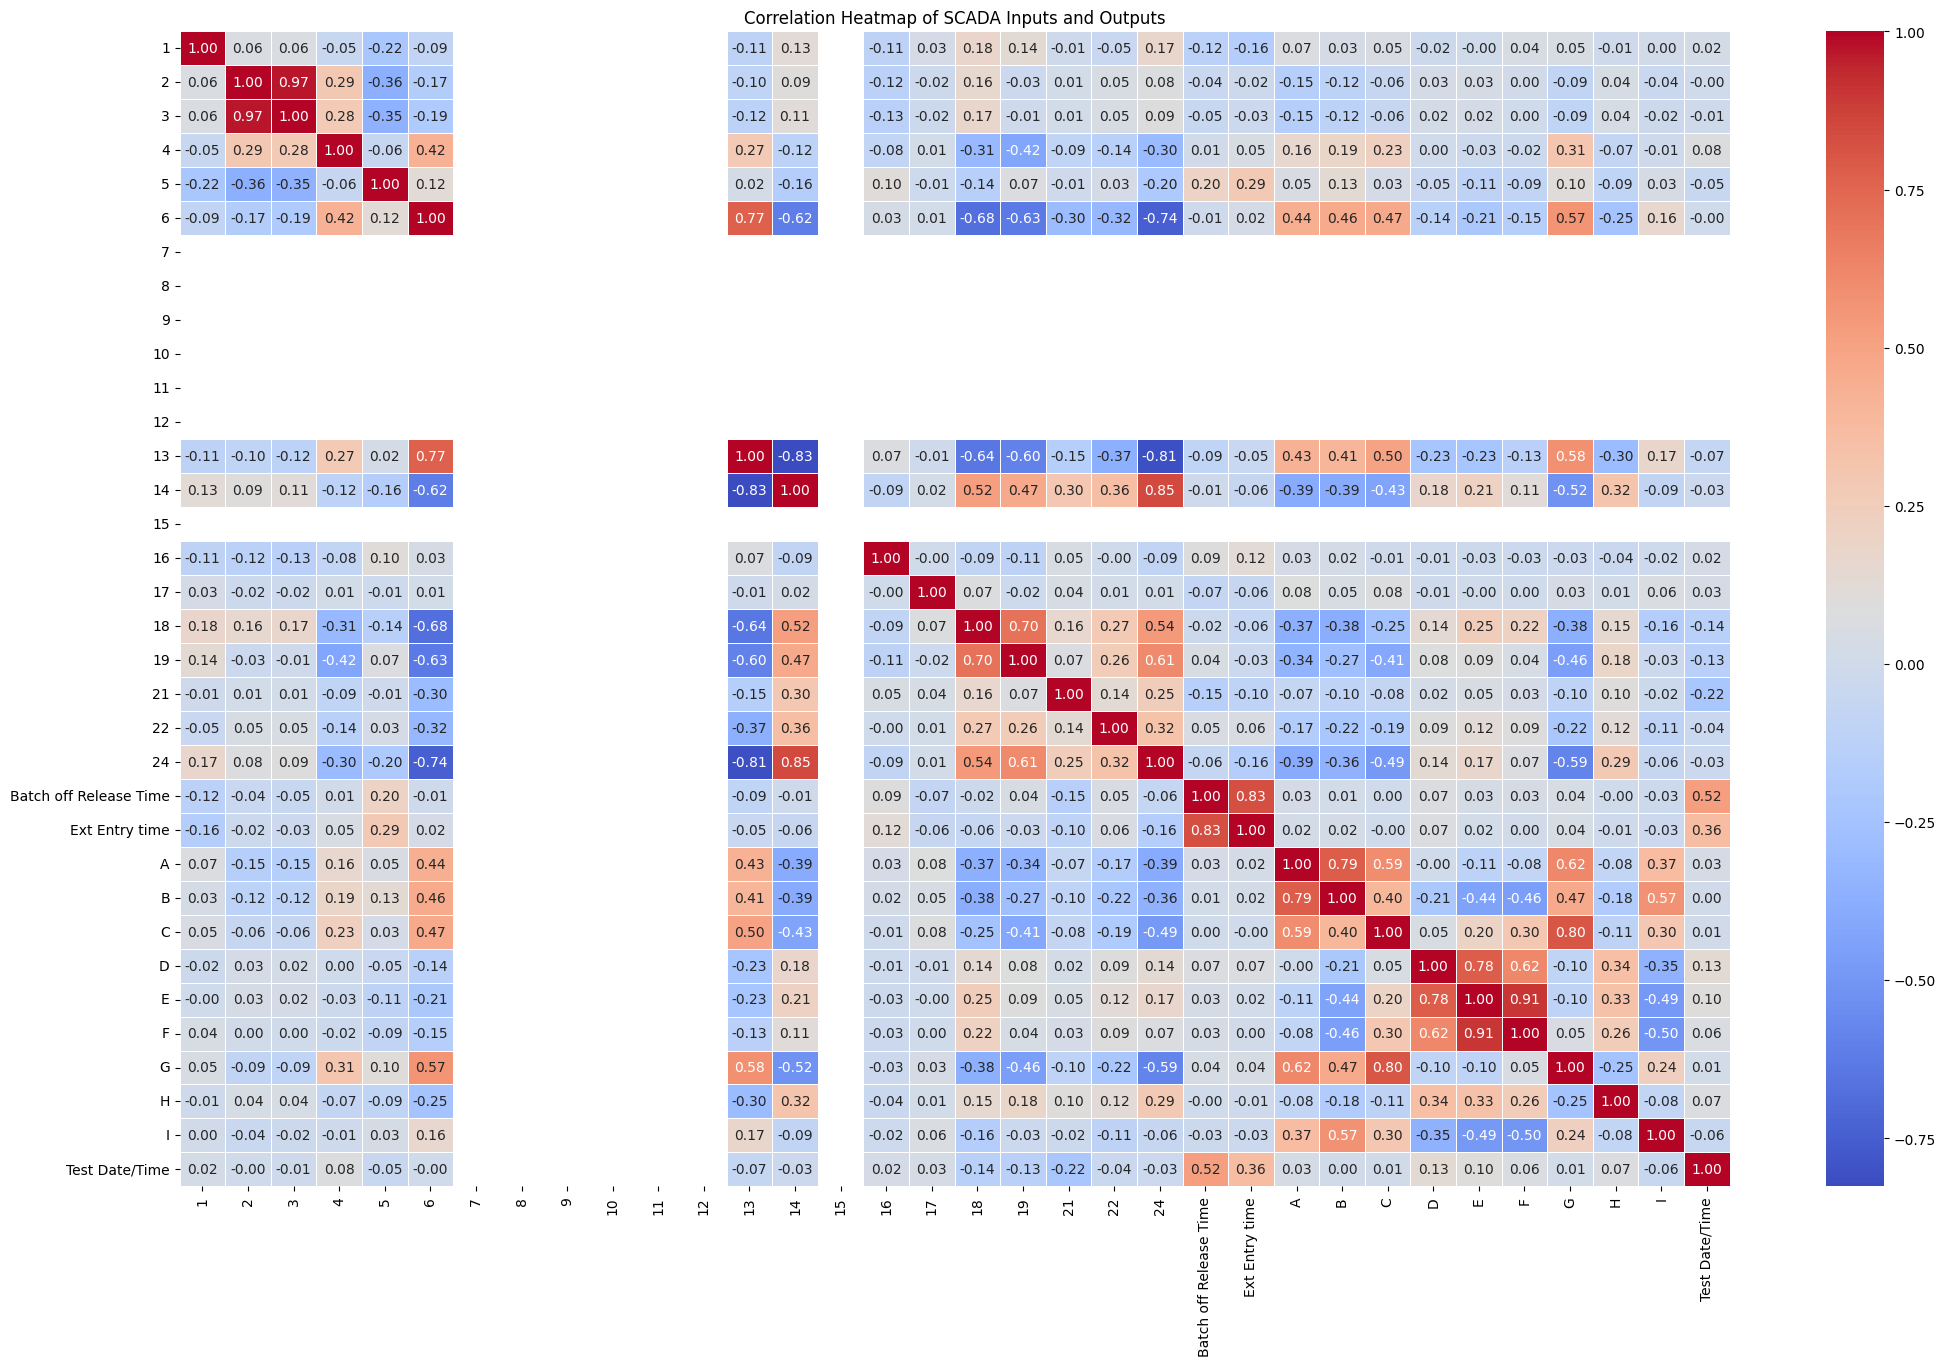

In [312]:
correlation_matrix = df_xy.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of SCADA Inputs and Outputs")
plt.show()

Setting the X and Y with columns with unique valeus

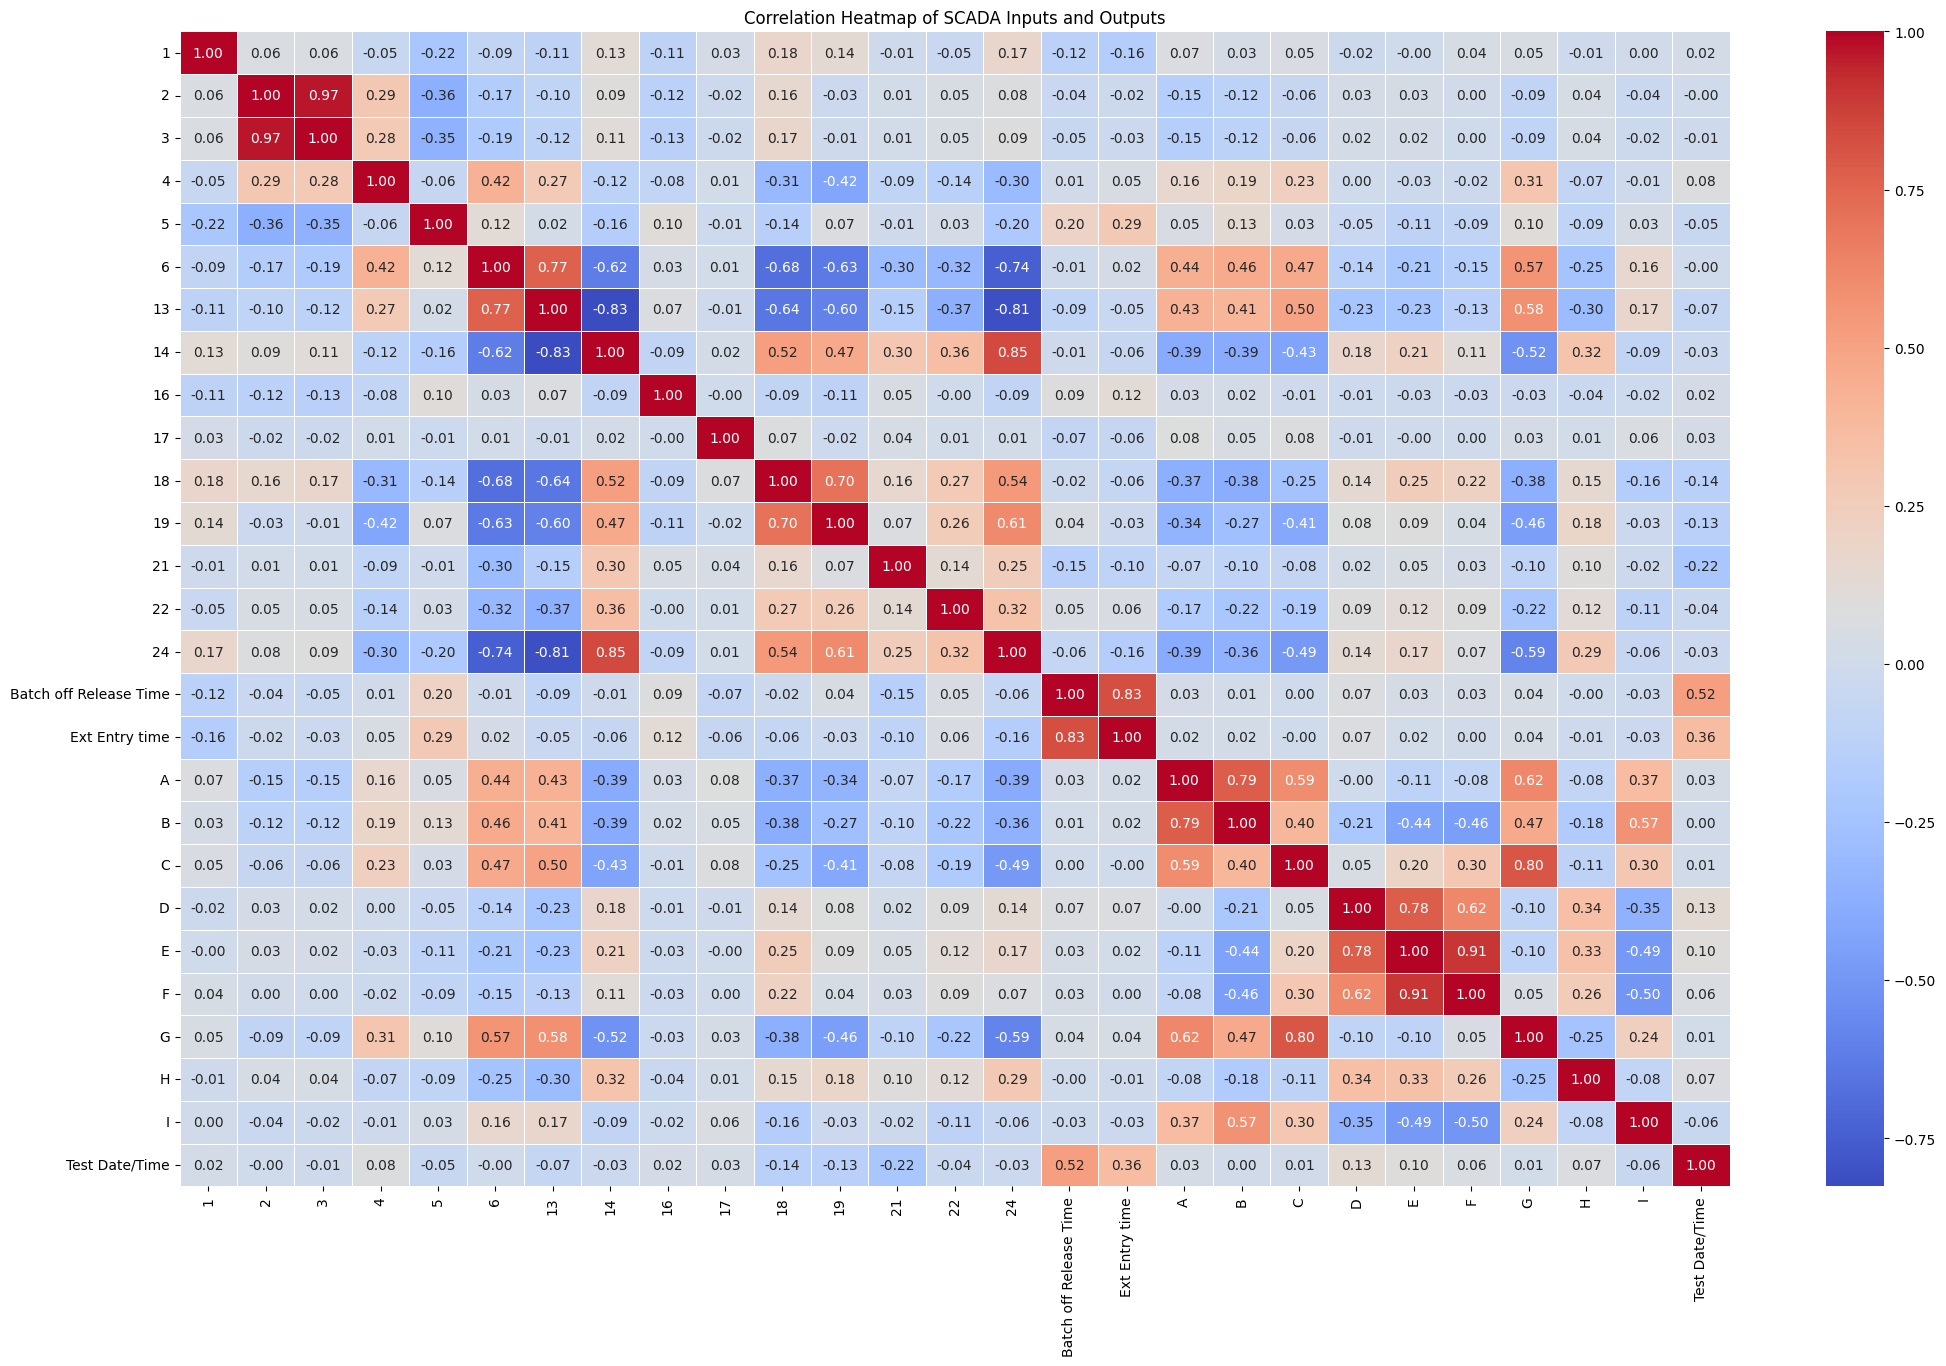

In [313]:

x = ['1', '2', '3', '4', '5', '6', '13', '14', '16', '17', '18', '19', '21', '22', '24', 'Batch off Release Time', 'Ext Entry time']
y = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'Test Date/Time']

df_xy_1 = copy.deepcopy(df_xy[x + y])
correlation_matrix = df_xy_1.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of SCADA Inputs and Outputs")
plt.show()

Plotting the heatmap for X against Y only

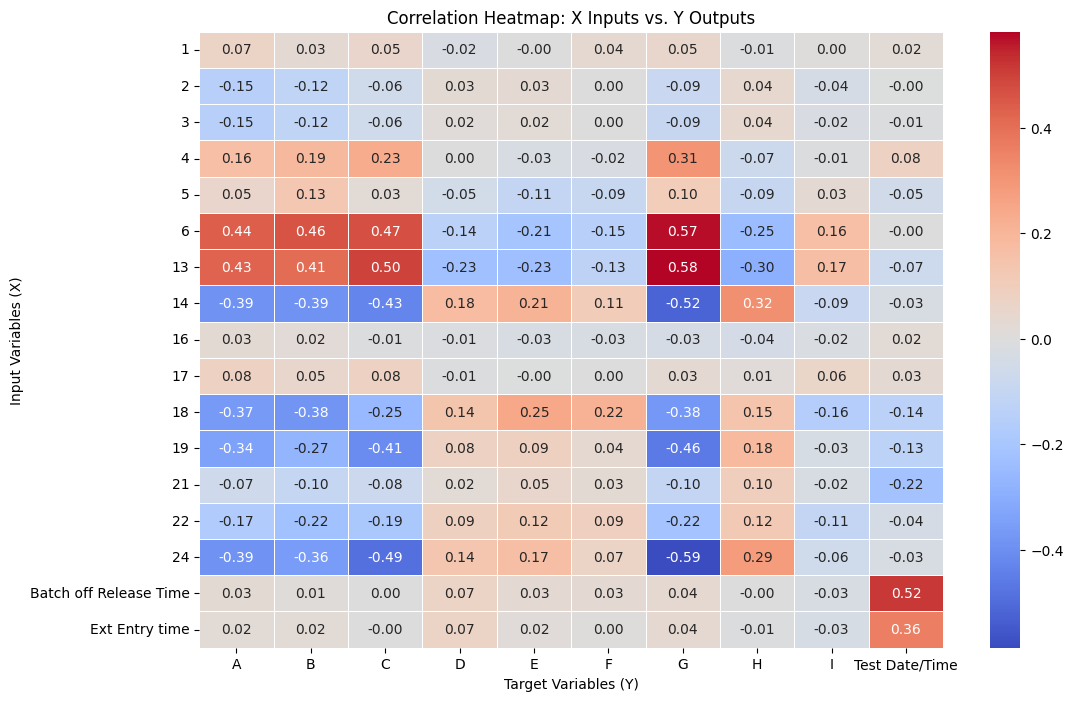

In [314]:

correlation_df = pd.DataFrame(correlation_matrix, index=x, columns=y)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Target Variables (Y)")
plt.ylabel("Input Variables (X)")
plt.title("Correlation Heatmap: X Inputs vs. Y Outputs")

plt.show()


Selecting the best inputs based on correlation value

In [432]:
x = ['1', '2', '3', '4', '5', '6', '13', '14', '16', '17', '18', '19', '21', '22', '24', 'Ext Entry time']
y = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'Test Date/Time']

df_xy_2 = copy.deepcopy(df_xy_1[x+y])

df_xy_2.set_index('Ext Entry time', inplace=True)
df_xy_2 = df_xy_2.sort_index()

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

available_x = [col for col in x if col in df_xy_2.columns]
available_y = [col for col in y if col in df_xy_2.columns]

df_xy_2[available_x] = scaler_x.fit_transform(df_xy_2[available_x])
df_xy_2[available_y] = scaler_y.fit_transform(df_xy_2[available_y])

data_x = df_xy_2[available_x].values
data_y = df_xy_2[available_y].values

train_size = int(len(df_xy_2) * 0.8)
val_size = int(len(df_xy_2) * 0.1)

train_x, train_y = data_x[:train_size], data_y[:train_size]
val_x, val_y = data_x[train_size:train_size + val_size], data_y[train_size:train_size + val_size]
test_x, test_y = data_x[train_size + val_size:], data_y[train_size + val_size:]

def create_sequences(x, y, seq_length=10):
    x_seq, y_seq = [], []
    for i in range(len(x) - seq_length):
        x_seq.append(x[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(x_seq), np.array(y_seq)

seq_length = 10
train_x_seq, train_y_seq = create_sequences(train_x, train_y, seq_length)
val_x_seq, val_y_seq = create_sequences(val_x, val_y, seq_length)
test_x_seq, test_y_seq = create_sequences(test_x, test_y, seq_length)

print(f'training data: {train_x_seq.shape},{train_y_seq.shape}\nvalidation data: {val_x_seq.shape},{val_y_seq.shape}\ntesting data: {test_x_seq.shape},{test_y_seq.shape}')

training data: (517, 10, 15),(517, 10)
validation data: (55, 10, 15),(55, 10)
testing data: (57, 10, 15),(57, 10)


In [382]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Seed set to: {SEED}")

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=5,
                                 verbose=1,
                                 min_lr=1e-6)

early_stopper = EarlyStopping(monitor='val_loss',
                              #min_delta=0.001,
                              patience=10,
                              restore_best_weights=True,
                              verbose=1)

set_global_policy('mixed_float16')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Seed set to: 42
Using device: cpu


In [395]:
model = Sequential([
    LSTM(125, activation='tanh', return_sequences=True, input_shape=(seq_length, len(available_x))),
    Dropout(0.1),  # Add dropout after first LSTM layer
    LSTM(125, activation='tanh'),
    Dropout(0.1),  # Add another dropout
    Dense(len(available_y), dtype='float32')
])

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mse'])
model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 10, 125)        │        66,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 125)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 125)            │       125,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,260 (754.92 KB)

 Trainable params: 193,260 (754.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.1647 - mse: 0.3294 - val_loss: 0.1782 - val_mse: 0.3565 - learning_rate: 1.0000e-05
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1540 - mse: 0.3080 - val_loss: 0.1677 - val_mse: 0.3353 - learning_rate: 1.0000e-05
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1432 - mse: 0.2864 - val_loss: 0.1574 - val_mse: 0.3147 - learning_rate: 1.0000e-05
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1332 - mse: 0.2663 - val_loss: 0.1470 - val_mse: 0.2940 - learning_rate: 1.0000e-05
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1231 - mse: 0.2462 - val_loss: 0.1364 - val_mse: 0.2727 - learning_rate: 1.0000e-05
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1129 - mse: 0.2258 - val_loss: 0.1252 - val_mse: 0.2505 - learning_rate: 1.0000e-05
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1019 - mse: 0.2037 - val_loss: 0.1134 - val_mse: 0.2269 - lear

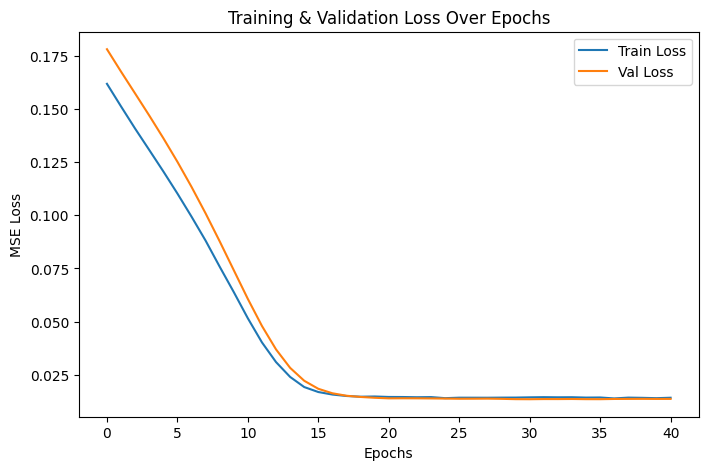

In [396]:

history = model.fit(train_x_seq,
                    train_y_seq, 
                    validation_data=(val_x_seq, val_y_seq), 
                    epochs=100,
                    batch_size=16, 
                    callbacks=[lr_scheduler, early_stopper],
                    verbose=1
                    )

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training & Validation Loss Over Epochs")
plt.show()


In [405]:
model.save("lstm_model.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!


Evaluating model

In [423]:
model_lstm = load_model("lstm_model.keras")

predictions = model_lstm.predict(test_x_seq)

rmse = np.sqrt(mean_squared_error(test_y_seq, predictions,multioutput='raw_values'))
mae = mean_absolute_error(test_y_seq, predictions,multioutput='raw_values')

print(f'Test RMSE: {rmse}\nTest MAE: {mae}')

test_loss, test_mse = model_lstm.evaluate(test_x_seq, test_y_seq)

print(f'\nAverage test Huber Loss: {test_loss:.4f}\nAverage Test MSE: {test_mse:.4f}')


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 14 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 677ms/step
Test RMSE: [0.15730977 0.15054454 0.11459793 0.1237237  0.07254689 0.0354384
 0.14892847 0.17225588 0.06384169 0.45566791]
Test MAE: [0.10505136 0.09930337 0.06824186 0.09051581 0.05077755 0.02837932
 0.10308809 0.13351709 0.04378577 0.44462653]
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0176 - mse: 0.0352

Average test Huber Loss: 0.0173
Average Test MSE: 0.0346


Saving Results

In [426]:
predictions_inv = scaler_y.inverse_transform(predictions)
test_y_inv = scaler_y.inverse_transform(test_y_seq)
percentage_error = np.abs((test_y_inv - predictions_inv) / test_y_inv) * 100

test_x_last_step = test_x_seq[:, -1, :]
test_x_inv = scaler_x.inverse_transform(test_x_last_step)

results_df = pd.DataFrame(np.hstack((test_x_inv, test_y_inv, predictions_inv, percentage_error)),
                          columns=[f"X_{i+1}" for i in range(test_x_inv.shape[1])] +
                                  [f"Actual_Y_{i+1}" for i in range(test_y_inv.shape[1])] +
                                  [f"Predicted_Y_{i+1}" for i in range(predictions_inv.shape[1])] +
                                  [f"Error_Y_{i+1} (%)" for i in range(percentage_error.shape[1])])

results_df.to_csv("results_of_lstm.csv", index=False)
print("Results saved to `results_of_lstm.csv`")


Results saved to `results_of_lstm.csv`


Rechecking the dimension of processed data vectors

In [433]:
print(f'training data: {train_x.shape},{train_y.shape}\nvalidation data: {val_x.shape},{val_y.shape}\ntesting data: {test_x.shape},{test_y.shape}')

training data: (527, 15),(527, 10)
validation data: (65, 15),(65, 10)
testing data: (67, 15),(67, 10)


1) Multi-Output Random Forest Model
2) Save the Random Forest model

In [434]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(train_x, train_y)

joblib.dump(model, "random_forest_model_2.pkl")
print("Random Forest Model Trained and Saved Successfully!")


Random Forest Model Trained and Saved Successfully!


1) Model evaluation and metrics
2) Saving Model prediction results

In [ ]:
model_rfr = joblib.load("random_forest_model.pkl")
print("Random Forest Model Loaded Successfully!")

val_preds = model.predict(val_x)
test_preds = model.predict(test_x)

val_mse = mean_squared_error(val_y, val_preds, multioutput='raw_values')
val_r2  = r2_score(val_y, val_preds, multioutput='raw_values')

print(f'Validation MSE per output: {val_mse}\nvValidation R^2 per output: {val_r2}')

test_mse = mean_squared_error(test_y, test_preds, multioutput='raw_values')
test_r2  = r2_score(test_y, test_preds, multioutput='raw_values')

print(f'\nTest mse per output: {test_mse}\nTest R^2 per output: {test_r2}')

predictions_inv = scaler_y.inverse_transform(test_preds)
test_y_inv = scaler_y.inverse_transform(test_y)
test_x_inv = scaler_x.inverse_transform(test_x)

percentage_error = np.abs((test_y_inv - predictions_inv) / test_y_inv) * 100

import pandas as pd

results_df = pd.DataFrame(
    np.hstack((test_x_inv, test_y_inv, predictions_inv, percentage_error)),
    columns=[f"X_{i+1}" for i in range(test_x_inv.shape[1])] +
            [f"Actual_Y_{i+1}" for i in range(test_y_inv.shape[1])] +
            [f"Predicted_Y_{i+1}" for i in range(predictions_inv.shape[1])] +
            [f"Error_Y_{i+1} (%)" for i in range(percentage_error.shape[1])]
)

results_df.to_csv("results_of_RFR_2.csv", index=False)
print("Results saved to `results_of_RFR.csv`")


Random Forest Model Loaded Successfully!
Validation MSE per output: [0.00827949 0.01320985 0.00291083 0.03472117 0.02109585 0.01726615
 0.00781017 0.01824877 0.0127553  0.03858124]
vValidation R^2 per output: [ 0.33370788  0.29539462  0.54133407 -0.48812897 -0.63347336 -0.38098384
  0.60350437 -0.10309492 -0.04095814 -1.01488042]

Test mse per output: [0.01652762 0.01625257 0.00918746 0.01381506 0.00771061 0.00657515
 0.0113297  0.02772138 0.00394841 0.17063234]
Test R^2 per output: [ 2.59707027e-01  1.98164927e-01  2.01401931e-01  1.66344842e-03
 -7.74195827e-01 -1.49666045e+01  4.74792117e-01  5.25194200e-02
 -1.28493048e-01 -1.38479045e+01]
Results saved to `results_of_RFR.csv`


Feature Importances

Feature Importances (overall):
21: 0.2164
22: 0.1410
18: 0.0944
13: 0.0908
24: 0.0819
1: 0.0682
17: 0.0668
4: 0.0488
19: 0.0479
16: 0.0468
5: 0.0304
3: 0.0296
2: 0.0281
6: 0.0078
14: 0.0012


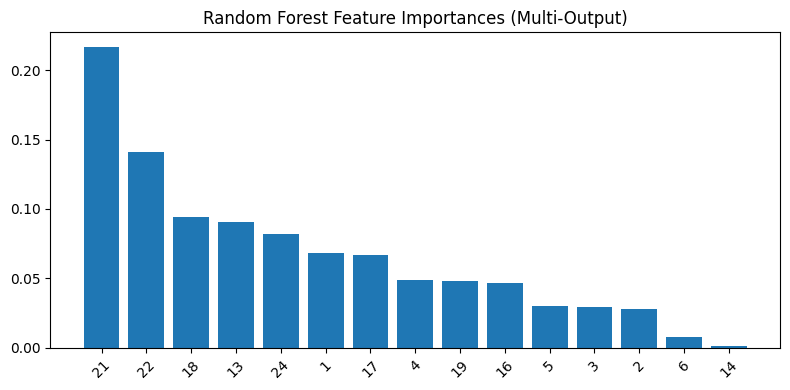

In [436]:
importances = model.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [available_x[i] for i in sorted_indices]

print("Feature Importances (overall):")
for name, imp in zip(sorted_features, sorted_importances):
    print(f"{name}: {imp:.4f}")

plt.figure(figsize=(8, 4))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45)
plt.title("Random Forest Feature Importances (Multi-Output)")
plt.tight_layout()
plt.show()


Optimizing input for minimizing prediction error

In [438]:

def objective_function(x, target_output, output_index, model):
    x = np.array(x).reshape(1, -1)
    prediction = model.predict(x)[0, output_index]
    error = np.abs(prediction - target_output)
    return error

input_min = np.min(train_x, axis=0)
input_max = np.max(train_x, axis=0)
bounds = [(input_min[i], input_max[i]) for i in range(train_x.shape[1])]

optimized_results = []

for output_index in range(test_y.shape[1]):
    target_output = np.median(test_y[:, output_index])
    
    initial_guess = np.mean(train_x, axis=0)

    result = minimize(
        objective_function, 
        initial_guess, 
        args=(target_output, output_index, model), 
        method='L-BFGS-B',
        bounds=bounds
    )

    optimized_results.append(result.x)

    print(f"Optimized Inputs for SCADA Output {output_index+1}: {result.x}\nFinal Error: {result.fun:.4f}\n")

optimized_df = pd.DataFrame(optimized_results, columns=[f"X_{i+1}" for i in range(train_x.shape[1])])
optimized_df.to_csv("optimized_inputs_RFR.csv", index=False)

print("Optimized Input Parameters Saved to `optimized_inputs.csv`")


Optimized Inputs for SCADA Output 1: [0.54132909 0.71750474 0.6626945  0.55299539 0.53673082 0.50126502
 0.63259013 0.26944972 0.77240333 0.03047849 0.52648956 0.35069225
 0.16254817 0.04608685 0.39926331]
Final Error: 0.0194

Optimized Inputs for SCADA Output 2: [0.54132909 0.71750474 0.6626945  0.55299539 0.53673082 0.50126502
 0.63259013 0.26944972 0.77240333 0.03047849 0.52648956 0.35069225
 0.16254817 0.04608685 0.39926331]
Final Error: 0.0060

Optimized Inputs for SCADA Output 3: [0.54132909 0.71750474 0.6626945  0.55299539 0.53673082 0.50126502
 0.63259013 0.26944972 0.77240333 0.03047849 0.52648956 0.35069225
 0.16254817 0.04608685 0.39926331]
Final Error: 0.0028

Optimized Inputs for SCADA Output 4: [0.54132909 0.71750474 0.6626945  0.55299539 0.53673082 0.50126502
 0.63259013 0.26944972 0.77240333 0.03047849 0.52648956 0.35069225
 0.16254817 0.04608685 0.39926331]
Final Error: 0.0287

Optimized Inputs for SCADA Output 5: [0.54132909 0.71750474 0.6626945  0.55299539 0.53673082

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


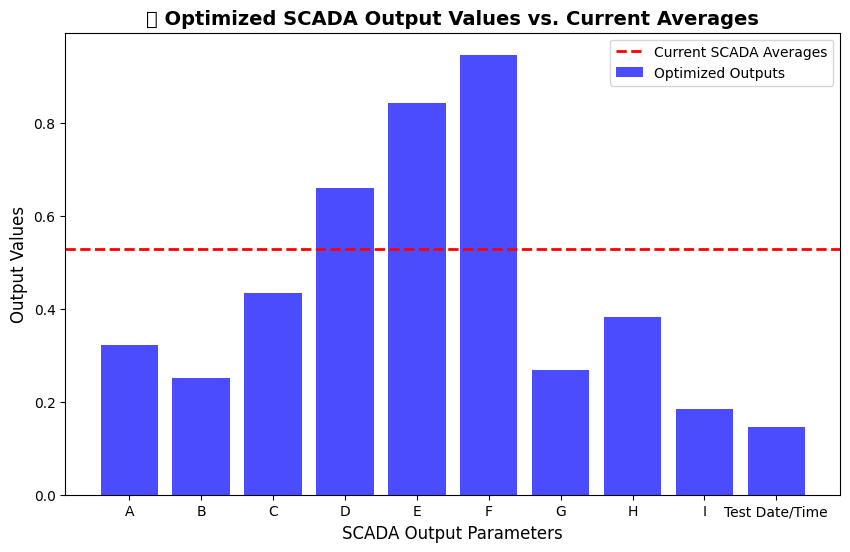

In [440]:
optimized_inputs = pd.read_csv("optimized_inputs_RFR.csv").values

optimized_outputs = model.predict(optimized_inputs)

current_averages = np.mean(test_y, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(available_y, np.mean(optimized_outputs, axis=0), color='blue', alpha=0.7, label="Optimized Outputs")
plt.axhline(np.mean(current_averages), color='red', linestyle='dashed', linewidth=2, label="Current SCADA Averages")
plt.xlabel("SCADA Output Parameters", fontsize=12)
plt.ylabel("Output Values", fontsize=12)
plt.title("🔹 Optimized SCADA Output Values vs. Current Averages", fontsize=14, fontweight='bold')
plt.legend()
plt.show()
